# Project 3 - Reddit NLP
## 04-First Model: Multinomial Naive Bayes

For my first model, I will run a gridsearch over a Multinomial Naive Bayes twice - once with CountVectorizer, and once with TfidfVectorizer so that I can compare the two. I then create a pipeline with my best model for ease of interpretability. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [32]:
df = pd.read_csv('./data/legal_nsq_clean.csv')

In [33]:
df.head(2)

,created_utc,subreddit,author,media_only,permalink,clean_text,clean_title,alltext_clean,alltext_word_count,title_word_count,selftext_word_count
0,1601524380,legaladvice,Gtormund51,False,/r/legaladvice/comments/j31aqq/my_ex_gf_refuse...,About a week ago I ended a moderately long rel...,My ex gf refuses to reclaim her items from my ...,My ex gf refuses to reclaim her items from my ...,136,23,113
1,1601524283,legaladvice,hustlegoat,False,/r/legaladvice/comments/j319w1/a_car_is_advert...,So I'm looking for a new car and I stumbled up...,A car is advertised for 18 000 lower than MSRP...,A car is advertised for 18 000 lower than MSRP...,105,21,85


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55713 entries, 0 to 55712
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_utc          55713 non-null  int64 
 1   subreddit            55713 non-null  object
 2   author               55713 non-null  object
 3   media_only           55713 non-null  bool  
 4   permalink            55713 non-null  object
 5   clean_text           55713 non-null  object
 6   clean_title          55713 non-null  object
 7   alltext_clean        55713 non-null  object
 8   alltext_word_count   55713 non-null  int64 
 9   title_word_count     55713 non-null  int64 
 10  selftext_word_count  55713 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 4.3+ MB


### Baseline/Null Model

As shown below, our baseline model is 52% accuracy.

In [35]:
df['subreddit'].value_counts(normalize=True)

legaladvice          0.515607
NoStupidQuestions    0.484393
Name: subreddit, dtype: float64

### Set up X and y and train/test/split

In [5]:
df['subreddit'], names = pd.factorize(df['subreddit'])

In [7]:
X = df['alltext_clean']
y = df['subreddit']

In [8]:
X.head()

0    My ex gf refuses to reclaim her items from my ...
1    A car is advertised for 18 000 lower than MSRP...
2    Can my boss make me 16 year old work 28.5 hour...
3    I m leaving him and taking the dog. What can I...
4    NONPROFIT T SHIRT LOGO infringement???Can I be...
Name: alltext_clean, dtype: object

In [9]:
y.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        0
        ..
55708    1
55709    1
55710    1
55711    1
55712    1
Name: subreddit, Length: 55713, dtype: int64>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [11]:
X_train.shape

(41784,)

In [12]:
y_train.shape

(41784,)

### Lemmatizing

I will create a function for lemmatizing that I can use as a preprocessor in the grid search. I will also grid search over two different stop words in accordance with the preprocessors.

In [13]:
def split_lem(text):
    text = text.lower()
    lem = WordNetLemmatizer()
    return ' '.join([lem.lemmatize(word) for word in text.split()])

### GridSearchCV with CountVectorizer

In [14]:
pipe = make_pipeline(CountVectorizer(), MultinomialNB())

params = {
    'countvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'countvectorizer__min_df': [5, .05],
    'countvectorizer__preprocessor': [None, split_lem],
    'countvectorizer__stop_words': ['english', stopwords.words('english')]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

grid.fit(X_train, y_train)

print('Training score: ', grid.score(X_train, y_train))
print('Testing score: ', grid.score(X_test, y_test))

Training score:  0.9450028719126938
Testing score:  0.9315097996984708


In [15]:
print('Best parameters: ', grid.best_params_)

Best parameters:  {'countvectorizer__min_df': 5, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__preprocessor': None, 'countvectorizer__stop_words': 'english'}


### GridSearchCV with TfidfVectorizer 

In [25]:
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

params = {
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidfvectorizer__min_df': [5, .05],
    'tfidfvectorizer__preprocessor': [None, split_lem],
    'tfidfvectorizer__stop_words': ['english', stopwords.words('english')]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

grid.fit(X_train, y_train)

print('Training score: ', grid.score(X_train, y_train))
print('Testing score: ', grid.score(X_test, y_test))
print('Best parameters: ', grid.best_params_)

Training score:  0.9135793605207735
Testing score:  0.8998492354081413
Best parameters:  {'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__preprocessor': None, 'tfidfvectorizer__stop_words': 'english'}


**Model Comparison**: Both the training and testing scores were higher using CountVectorizer. The min_df value is 5 for both models, rather than 5%. Both models selected No Preprocessor and the standard 'english' stopwords. CountVectorizer uses unigrams and bigrams, whereas TfidfVectorizer only uses unigrams.

### Additional Classification Metrics

In [20]:
y_preds = nbayes_pipe.predict(X_test)

In [22]:
balanced_accuracy_score(y_test, y_preds)

0.9306999741284443

In [21]:
f1_score(y_test, y_preds)

0.928913443830571

**Metrics Analysis:** The f1 score is close to 1. This indicates that the model is well balanced, and does not favor either precision or or recall. The balanced accuracy score is also close to 1, indicating that performance is evenly weighted between the two classes. This is expected, since our classes were relatively well represented.


### Pipeline for Interpretability
I will use the best parameters from the CountVectorizer Grid Search to build a pipeline for increased interpretability.

In [16]:
nbayes_pipe = make_pipeline(
    CountVectorizer(stop_words = stopwords.words('english'), min_df=5, ngram_range=(1,2)), 
    MultinomialNB())

In [17]:
nbayes_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('multinomialnb', MultinomialNB())])

In [18]:
nbayes_pipe.score(X_train, y_train)

0.9463670304422745

In [19]:
nbayes_pipe.score(X_test, y_test)

0.9307200804077823

### Visualizations

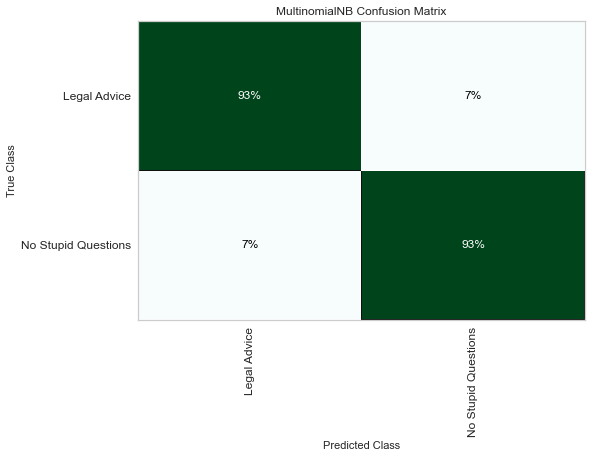

In [25]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
cm = ConfusionMatrix(
    nbayes_pipe, classes=['Legal Advice', 'No Stupid Questions'],
    percent=True,
    cmap='BuGn'
)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show();

**Confusion Matrix:** Here we can see that the model is very well balanced - it predicted 93% correctly for both classes, and false negatives and false positives are both 7%. If our goal is balance, this is a great model to use.

In [58]:
from yellowbrick.classifier import ROCAUC

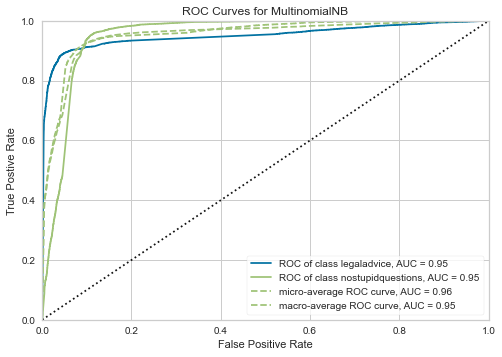

In [61]:
# idea provided by Alex Fioto
rocauc_viz = ROCAUC(nbayes_pipe, classes=['legaladvice', 'nostupidquestions'])
rocauc_viz.fit(X_train, y_train)
rocauc_viz.score(X_test, y_test)
rocauc_viz.show();

**ROC Curve:** This is a visual representation of our predictive ability, and the tradeoff between sensitivity and specificity. The curve is very close to the upper left hand corner, indicating strong predictability.